## Простейшие схемы для одномерного уравнения переноса

### $$\frac{\partial \phi}{\partial t} + u \frac{\partial \phi}{\partial x} = 0.$$

Ниже рассмотрены две схемы: 
1) С разностью вперёд по времени и центральными пространственными разностями (FTCS),
2) С разностью вперёд по времени и пространственными разностями против тока (upwind).

In [13]:
import numpy as np
import matplotlib.pyplot as plt

Зададим параметры задачи: скорость потока, пространственный и временной шаг. 

Число Куранта: $$C = \frac{u \Delta t}{\Delta x}.$$

In [14]:
u = 1.0
C = 0.1

nx = 100
L = 1.0
dx = L / nx

dt = C * dx / u
t_end = 0.3
nt = int(t_end / dt)

Зададим начальное распределение $\phi(x, 0) = \phi_0(x)$:
$$\phi_0(x) = 
\begin{cases}
1 & x \leq 0.3, \\
0 & x > 0.3.
\end{cases}$$

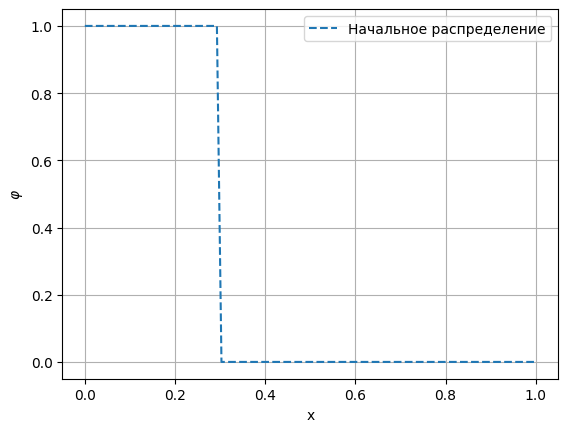

In [15]:
x = np.linspace(0, L, nx)
phi_left = 1.0
phi_right = 0.0
phi_0 = np.where(x <= 0.3, phi_left, phi_right)
plt.figure()
plt.plot(x, phi_0, '--', label='Начальное распределение')
plt.xlabel("x")
plt.ylabel(r"$\varphi$")
plt.legend()
plt.grid(True)
plt.show()

Схема с использованием центральной разности выглядит следующим образом:
$$\frac{\phi_i^{n+1} - \phi_i^n}{\Delta t} + u \frac{ \phi_{i+1}^n - \phi_{i-1}^n }{2 \Delta x} = 0$$
или
$$\phi_i^{n+1} = \phi_i^n - \frac{C}{2} \left( \phi_{i+1}^n - \phi_{i-1}^n \right).$$
Данная схема является абсолютно неустойчивой.

In [16]:
def central_scheme(phi):
    phi_new = phi.copy()
    for i in range(1, nx - 1):
        phi_new[i] = phi[i] - u * dt / (2 * dx) * (phi[i + 1] - phi[i - 1])
    return phi_new

Противопоточная схема:
$$\frac{\phi_i^{n+1} - \phi_i^n}{\Delta t} + u\frac{ \phi_i^n - \phi_{i-1}^n }{\Delta x} = 0$$
или
$$\phi_i^{n+1} = (1 - C) \phi_i^n + C \phi_{i-1}^n.$$
Данная схема устойчива при $C = \frac{u dt}{dx} \le 1$. При $C = 1$ получается **точное** решение.

In [37]:
def exp_upwind_scheme(phi):
    phi_new = phi.copy()
    for i in range(1, nx):
        phi_new[i] = phi[i] - u * dt / dx * (phi[i] - phi[i - 1])
    return phi_new

In [43]:
def exp_upwind_second_order(phi):
    phi_new = phi.copy()
    phi_new[1] = phi[1] - u * dt / dx * (phi[1] - phi[0])
    for i in range(2, nx):
        phi_new[i] = phi[i] - u * dt * 0.5 / dx * (3 * phi[i] - 4 * phi[i - 1] + phi[i - 2])
    return phi_new

In [44]:
# Инициализация
phi_central = phi_0.copy()
phi_exp_upwind = phi_0.copy()
phi_exp_upwind_2 = phi_0.copy()

In [45]:
for _ in range(nt):
    phi_central = central_scheme(phi_central)
    phi_exp_upwind = exp_upwind_scheme(phi_exp_upwind)
    phi_exp_upwind_2 = exp_upwind_second_order(phi_exp_upwind_2)

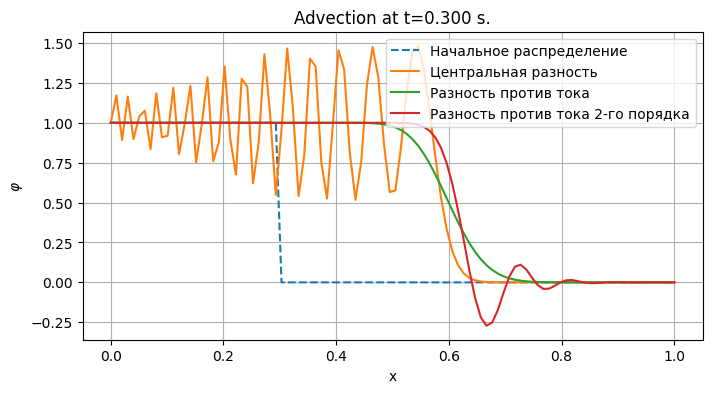

In [46]:
# Визуализация
plt.figure(figsize=(8, 4))
plt.plot(x, phi_0, label="Начальное распределение", linestyle="--")
plt.plot(x, phi_central, label="Центральная разность")
plt.plot(x, phi_exp_upwind, label="Разность против тока")
plt.plot(x, phi_exp_upwind_2, label="Разность против тока 2-го порядка")
plt.xlabel("x")
plt.ylabel(r"$\varphi$")
plt.legend()
plt.grid(True)
plt.title(f"Advection at t={dt*nt:.3f} s.")
plt.show()

"Размазывание" при использовании разности против тока обусловлено наличием сеточной вязкости:

$$\frac{\phi_i^{n+1}-\phi_i^n}{\Delta t}+u\frac{\phi_i^n-\phi_{i-1}^n}{\Delta x}=0.$$

Разложим в ряд Тейлора в окрестности $(x_i,t_n)$.

1. Временная аппроксимация (вперёд по времени):
$$\phi_i^{n+1}=\phi+\Delta t\,\phi_t+\frac{\Delta t^2}{2}\phi_{tt}+O(\Delta t^3)$$
откуда
$$\frac{\phi_i^{n+1}-\phi_i^n}{\Delta t}=\phi_t+\frac{\Delta t}{2}\phi_{tt}+O(\Delta t^2).$$

2. Пространственная аппроксимация:
$$\phi_{i-1}=\phi-\Delta x\,\phi_x+\frac{\Delta x^2}{2}\phi_{xx}-\frac{\Delta x^3}{6}\phi_{xxx}+O(\Delta x^4),$$
и
$$\frac{\phi_i-\phi_{i-1}}{\Delta x}=\phi_x-\frac{\Delta x}{2}\phi_{xx}+\frac{\Delta x^2}{6}\phi_{xxx}+O(\Delta x^3).$$

Подставляем в схему:
$$\Big(\phi_t+\frac{\Delta t}{2}\phi_{tt}\Big)+u\Big(\phi_x-\frac{\Delta x}{2}\phi_{xx}+\dots\Big)=0.$$

Используем, тот факт, что для невозмущённого уравнения переноса $\phi_t+u\phi_x=0$:
$$\phi_{tt}=\frac{\partial}{\partial t}(\phi_t)=-u(\phi_x)_t=-u(\phi_t)_x=-u(-u\phi_x)_x= u^2\phi_{xx}.$$

Подстановка даёт:
$$\phi_t+u\phi_x+\left(\frac{\Delta t}{2}u^2-\frac{u\Delta x}{2}\right)\phi_{xx}+ \text{(старшие члены)}=0.$$

Первые два слагаемых оставляем в левой части, а остальные переносим в правую, получаем модифицированное уравнение в форме:
$$\phi_t+u\phi_x=\nu_{\text{num}}\,\phi_{xx}+\dots,$$
где сеточная (искусственная) вязкость:
$$\nu_{\text{num}}=\frac{u\Delta x}{2}\big(1-C)$$
